<a href="https://colab.research.google.com/github/kaneda59/Classify_pictures_with_Deep_Learning/blob/main/Copie_de_deprez_fabrice_1_notebook_082023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install opencv-python
# !pip install scikit-learn
# !pip install keras
# !pip install tensorflow --user
# !pip install pydot graphviz
# !pip install wordcloud
# !pip install missingno

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# va permettre de ne plus avoir a recharger a chaque fois, il faut sauvegarder les modèles, les pkl et les poids + notebooks
# choisir content + path drive pour accéder aux données

In [3]:
#!cd drive/MyDrive/datas
!mkdir datas

In [4]:
#!cd datas
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

--2023-09-25 16:41:41--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  15.8MB/s    in 52s     

2023-09-25 16:42:33 (14.6 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [5]:
!mv images.tar ./datas

In [6]:
!cd datas ; tar -xvf images.tar

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane

In [7]:
# import  des librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from wordcloud import WordCloud
import missingno as msno
from IPython.display import Markdown, display

In [8]:
# -- cette fonction permet d'afficher du markdown dans la réponse de l'exécution d'un code
def markdown(string):
    display(Markdown(string))


# -- cette fonction permet d'afficher les informations complètes d'un dataframe
def show_informations(df, title):
    markdown(f'*** {title} ***')
    print("Total: {} enregistrements pour {} variables".format(df.shape[0],df.shape[1]))
    print(df.columns)
    print(df.info(verbose= True, show_counts=True))
    msno.bar(df)

# Chargement des données

In [9]:
path = "./datas/Images"
list = os.listdir(path)
print("nombre de classe de chiens : ", (len(list)))

nombre de classe de chiens :  120


In [10]:
!ls ./datas

Images	images.tar


Le dossier image contient 120 classes de chiens réparties dans 120 dossiers différents, il faut donc les stocker dans un dataframe

In [11]:
data = pd.DataFrame(list, columns=['Id_breed'])
data['breed_name'] = data['Id_breed'].apply(lambda x: x.split('-')[1])
data['Id']=data['Id_breed'].apply(lambda x: x.split('-')[0])
nb =[]
for name in data.Id_breed:
    nb.append(len(os.listdir(path + "/" + name)))
data['nb']=nb
print("nombre total d'images:", data['nb'].sum())

nombre total d'images: 20580


In [12]:
data.sample(5)

Id_breed                breed_name         Id  \
66                     n02088364-beagle                    beagle  n02088364   
76          n02091032-Italian_greyhound         Italian_greyhound  n02091032   
114  n02099849-Chesapeake_Bay_retriever  Chesapeake_Bay_retriever  n02099849   
9        n02106382-Bouvier_des_Flandres      Bouvier_des_Flandres  n02106382   
38           n02095889-Sealyham_terrier          Sealyham_terrier  n02095889   

      nb  
66   195  
76   182  
114  167  
9    150  
38   202

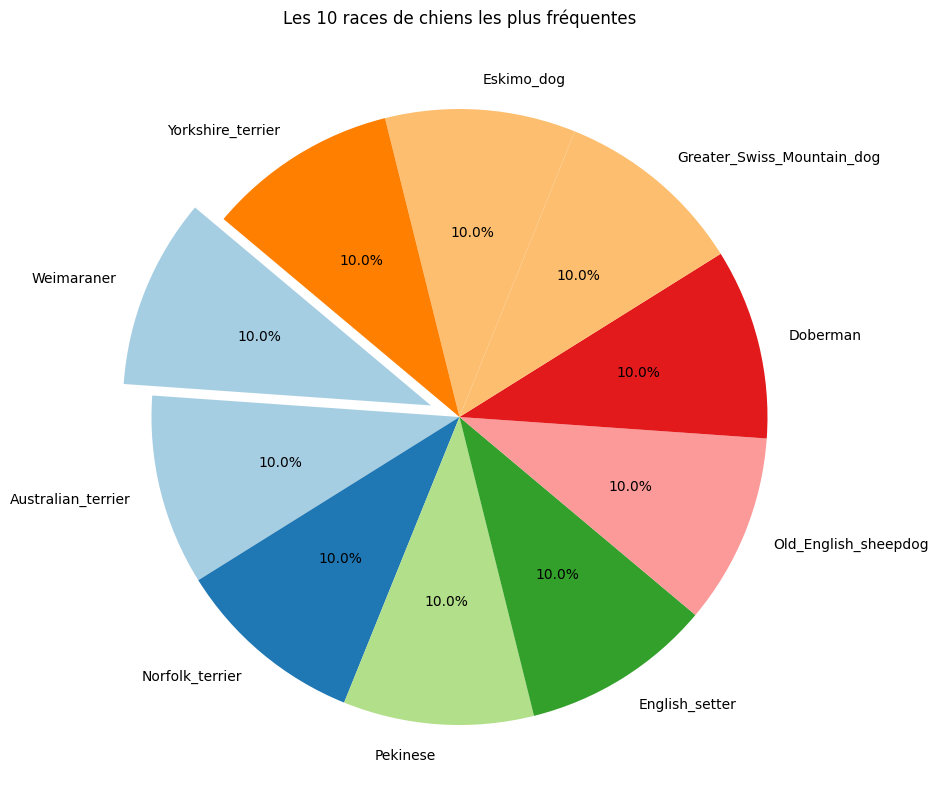

In [13]:
# Counting occurrences of each breed
breed_counts = data['breed_name'].value_counts()

# Colors
colors = plt.cm.Paired(np.linspace(0, 1, 15))

# Extracting top 10 breeds for clarity
top_breeds = breed_counts[:10]
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # exploding 1st slice for emphasis

# Plotting
plt.figure(figsize=(12, 10))
plt.pie(top_breeds, labels=top_breeds.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title("Les 10 races de chiens les plus fréquentes")
plt.show()

In [14]:
# faire un bar plot avec les 120 éléments

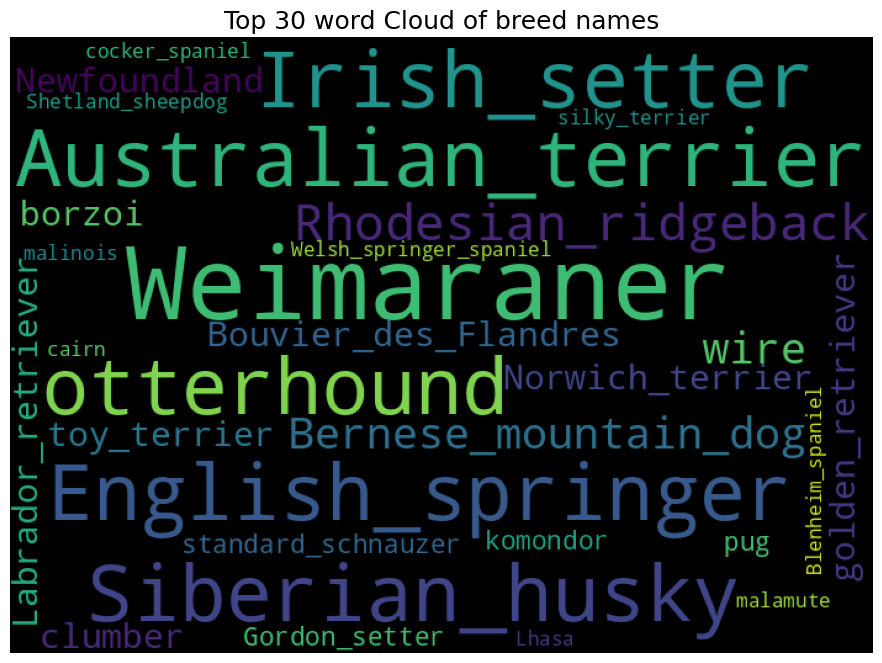

In [15]:
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=30, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(data.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 30 word Cloud of breed names", fontsize=18)
plt.show()

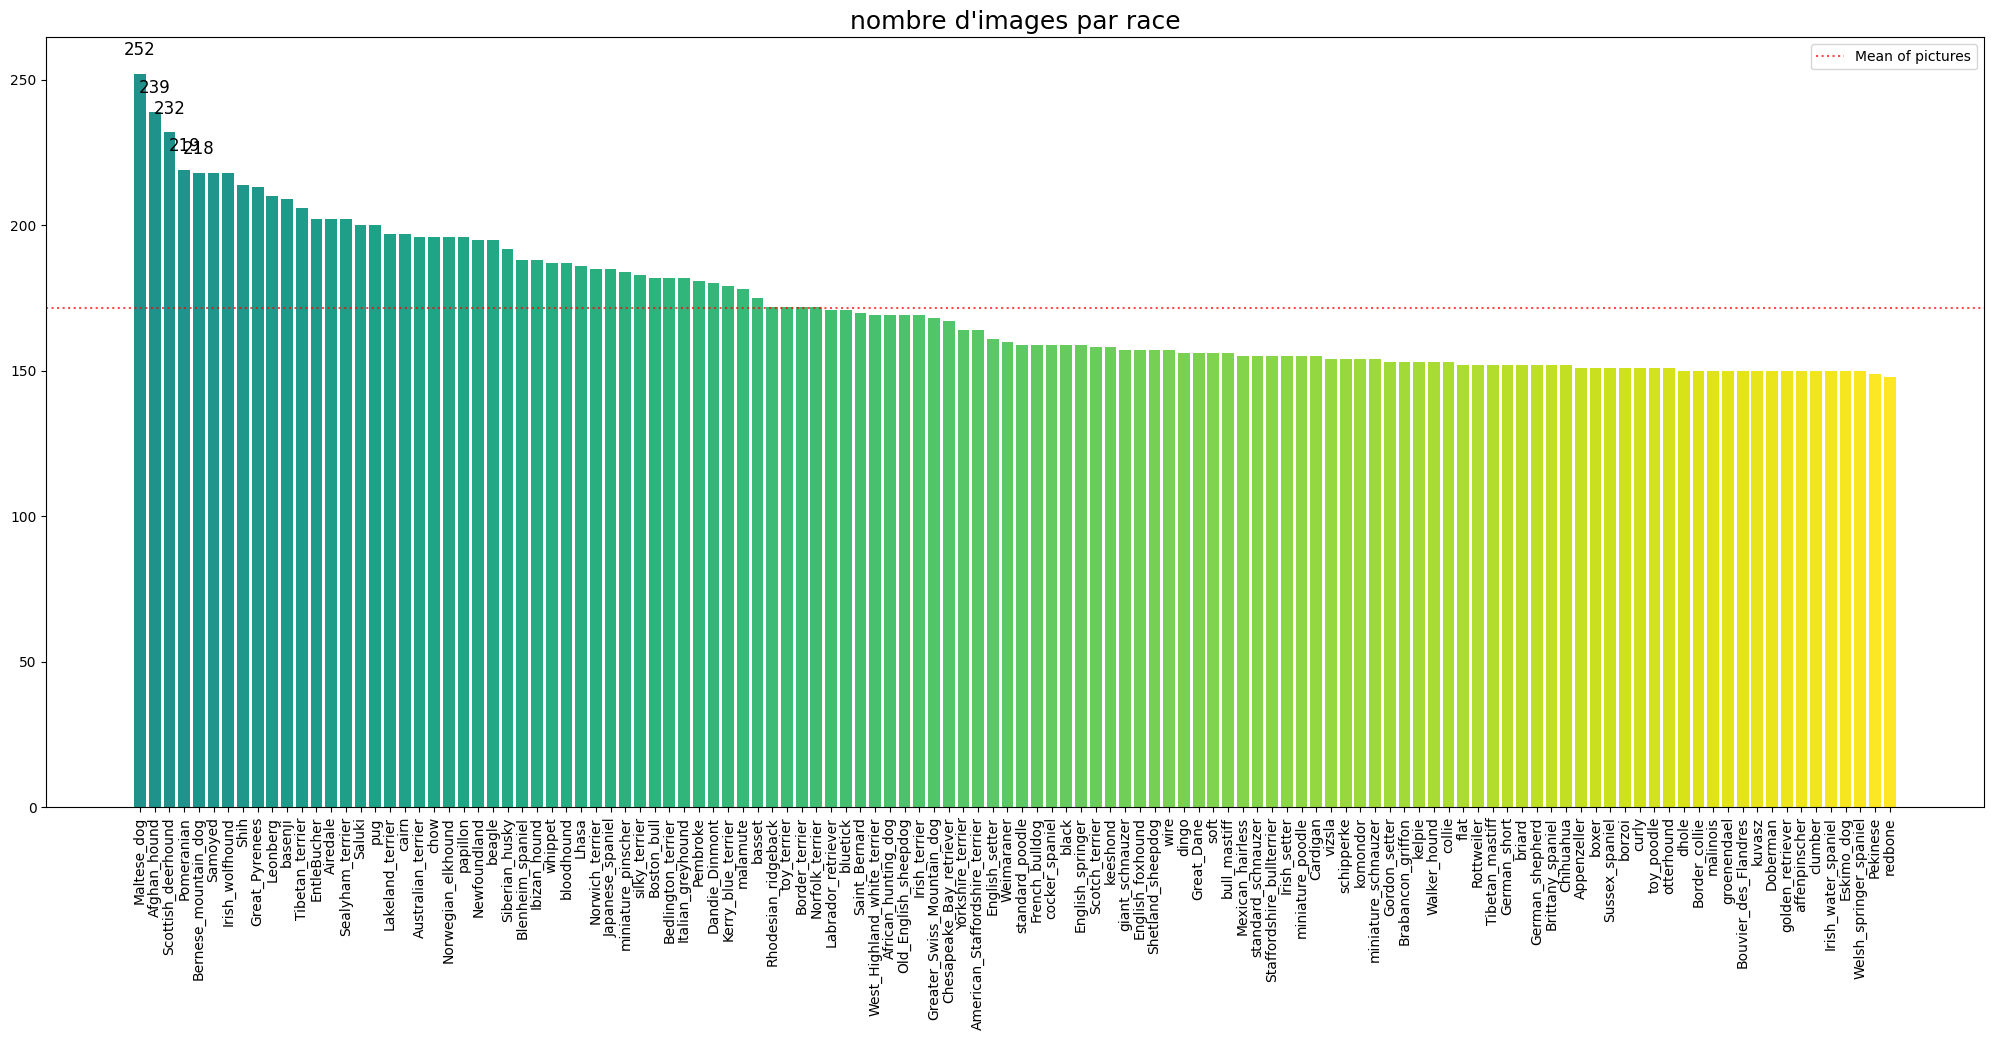

In [16]:
# trie des données sur 'nb'
df_sorted = data.sort_values(by='nb', ascending=False)

# creation d'un dégradé de couleur basé sur 'nb'
color_gradient = plt.cm.viridis(np.linspace(0.5, 1, len(df_sorted)))

# traçage
plt.figure(figsize=(25, 10))

bars = plt.bar(df_sorted['breed_name'], df_sorted['nb'], color=color_gradient)

# Ajouter des annotations aux 5 meilleures races
for i, bar in enumerate(bars[:5]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom', fontsize=12, color='black')

plt.axhline(df_sorted["nb"].mean(), color='red', alpha=.7, linestyle=':', label="Mean of pictures")
plt.title("nombre d'images par race", color='black', fontsize=18)
plt.xticks(rotation=90)
plt.legend()
plt.show()

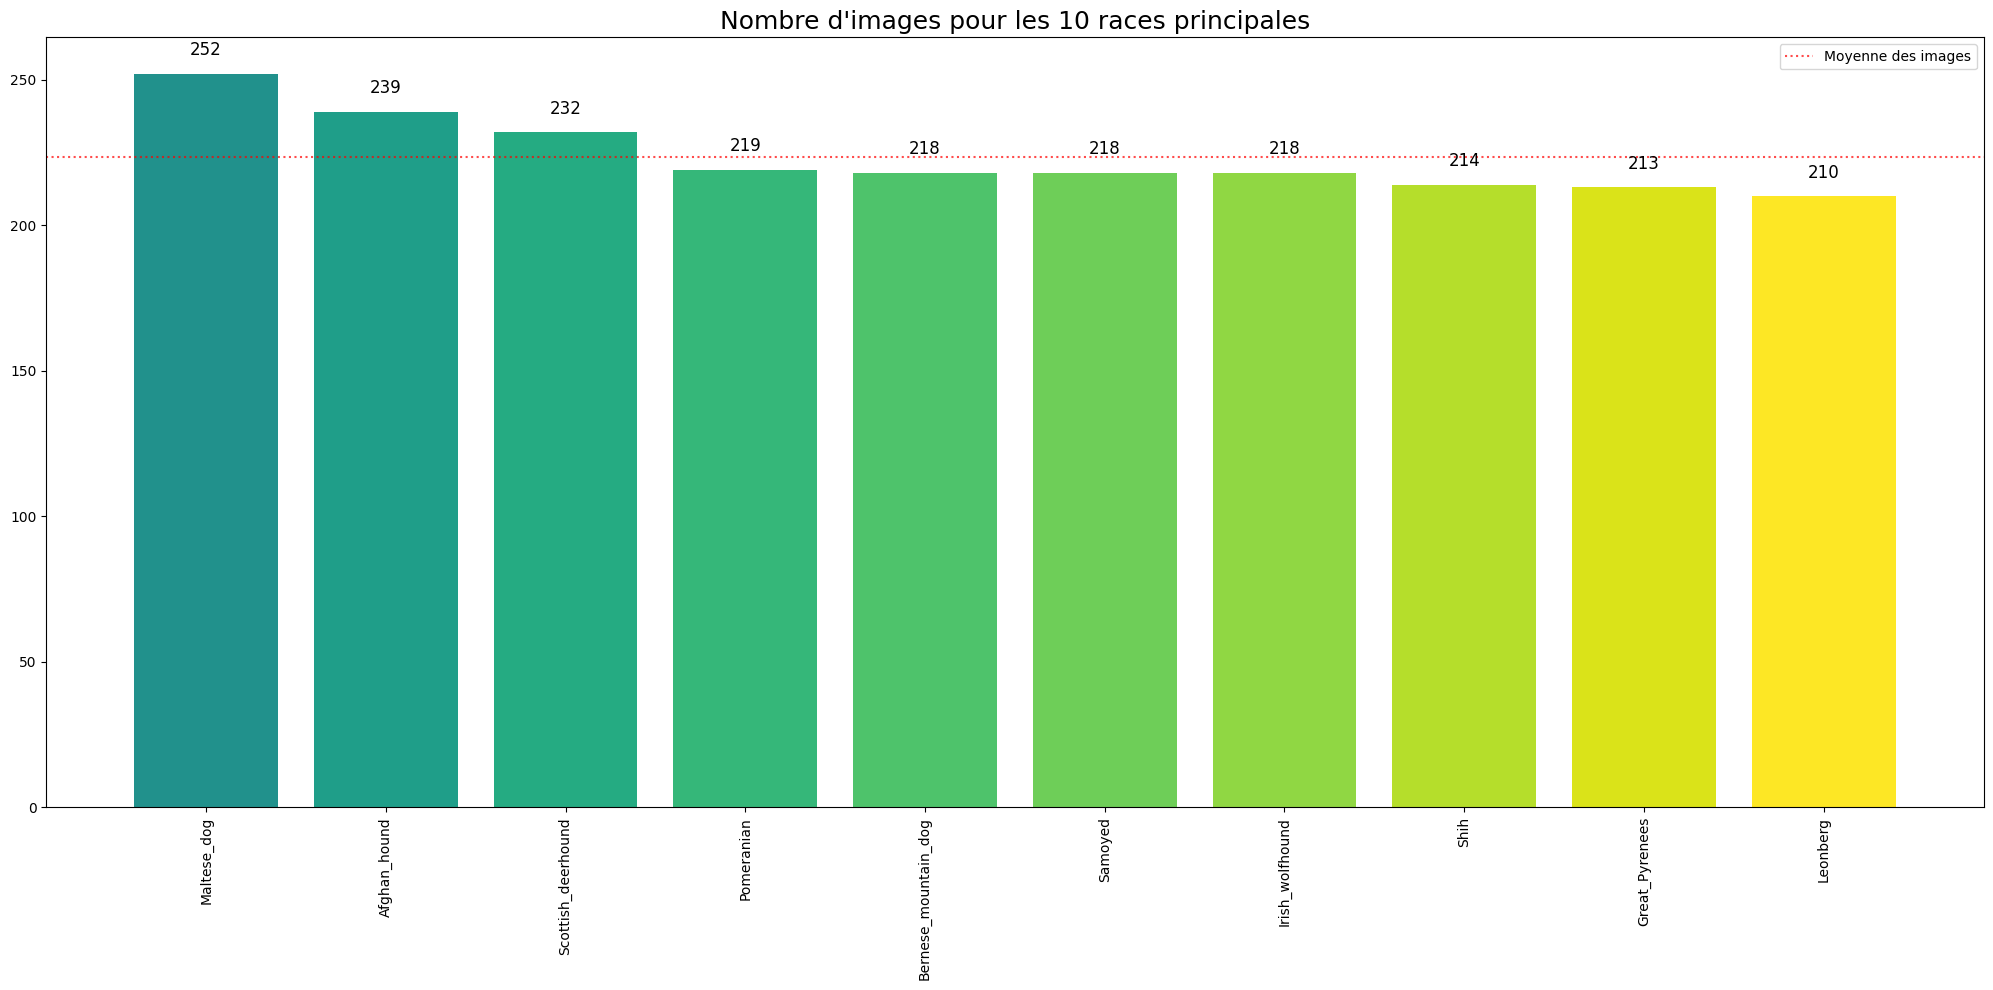

In [17]:
# Filtre pour ne garder que les 10 premières races par "nb".
top_10 = df_sorted.iloc[:10]

# Créez un gradient de couleur pour les 10 premiers.
color_gradient = plt.cm.viridis(np.linspace(0.5, 1, len(top_10)))

# Traçage
plt.figure(figsize=(25, 10))

bars = plt.bar(top_10['breed_name'], top_10['nb'], color=color_gradient)

# Ajouter des annotations à chacune des 10 races les plus importantes
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom', fontsize=12, color='black')

plt.axhline(top_10["nb"].mean(), color='red', alpha=.7, linestyle=':', label="Moyenne des images")
plt.title("Nombre d'images pour les 10 races principales", color='black', fontsize=18)
plt.xticks(rotation=90)
plt.legend()
plt.show()

Il faut créer un dataframe qui contient le chemin de toutes les images / races, ainsi que les caractéristiques de ces images

In [18]:
#liste de répertoires
uri_list=[]
for classe in data['Id_breed'].values:
    images = os.listdir(path + "/" + classe)
    for i in range(len(images)):
        uri_list.append(path+"/"+ classe +"/"+images[i])

#liste des images forme
df_img=[]
for uri in uri_list:
    df_img.append(mpimg.imread(uri).shape)

#data frame
df_img = pd.DataFrame(df_img, index = uri_list,columns=['heigth','width','color'])
#liste des races qui correspondent à chaque dossier
y = []
for j in range(120):
    for k in range(data.nb.values[j]):
        y.append(data.breed_name.values[j])

df_img['bread_name'] = y

*** analyse du dataframe image ***

Total: 20580 enregistrements pour 4 variables
Index(['heigth', 'width', 'color', 'bread_name'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 20580 entries, ./datas/Images/n02092339-Weimaraner/n02092339_2510.jpg to ./datas/Images/n02093991-Irish_terrier/n02093991_4052.jpg
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   heigth      20580 non-null  int64 
 1   width       20580 non-null  int64 
 2   color       20580 non-null  int64 
 3   bread_name  20580 non-null  object
dtypes: int64(3), object(1)
memory usage: 803.9+ KB
None


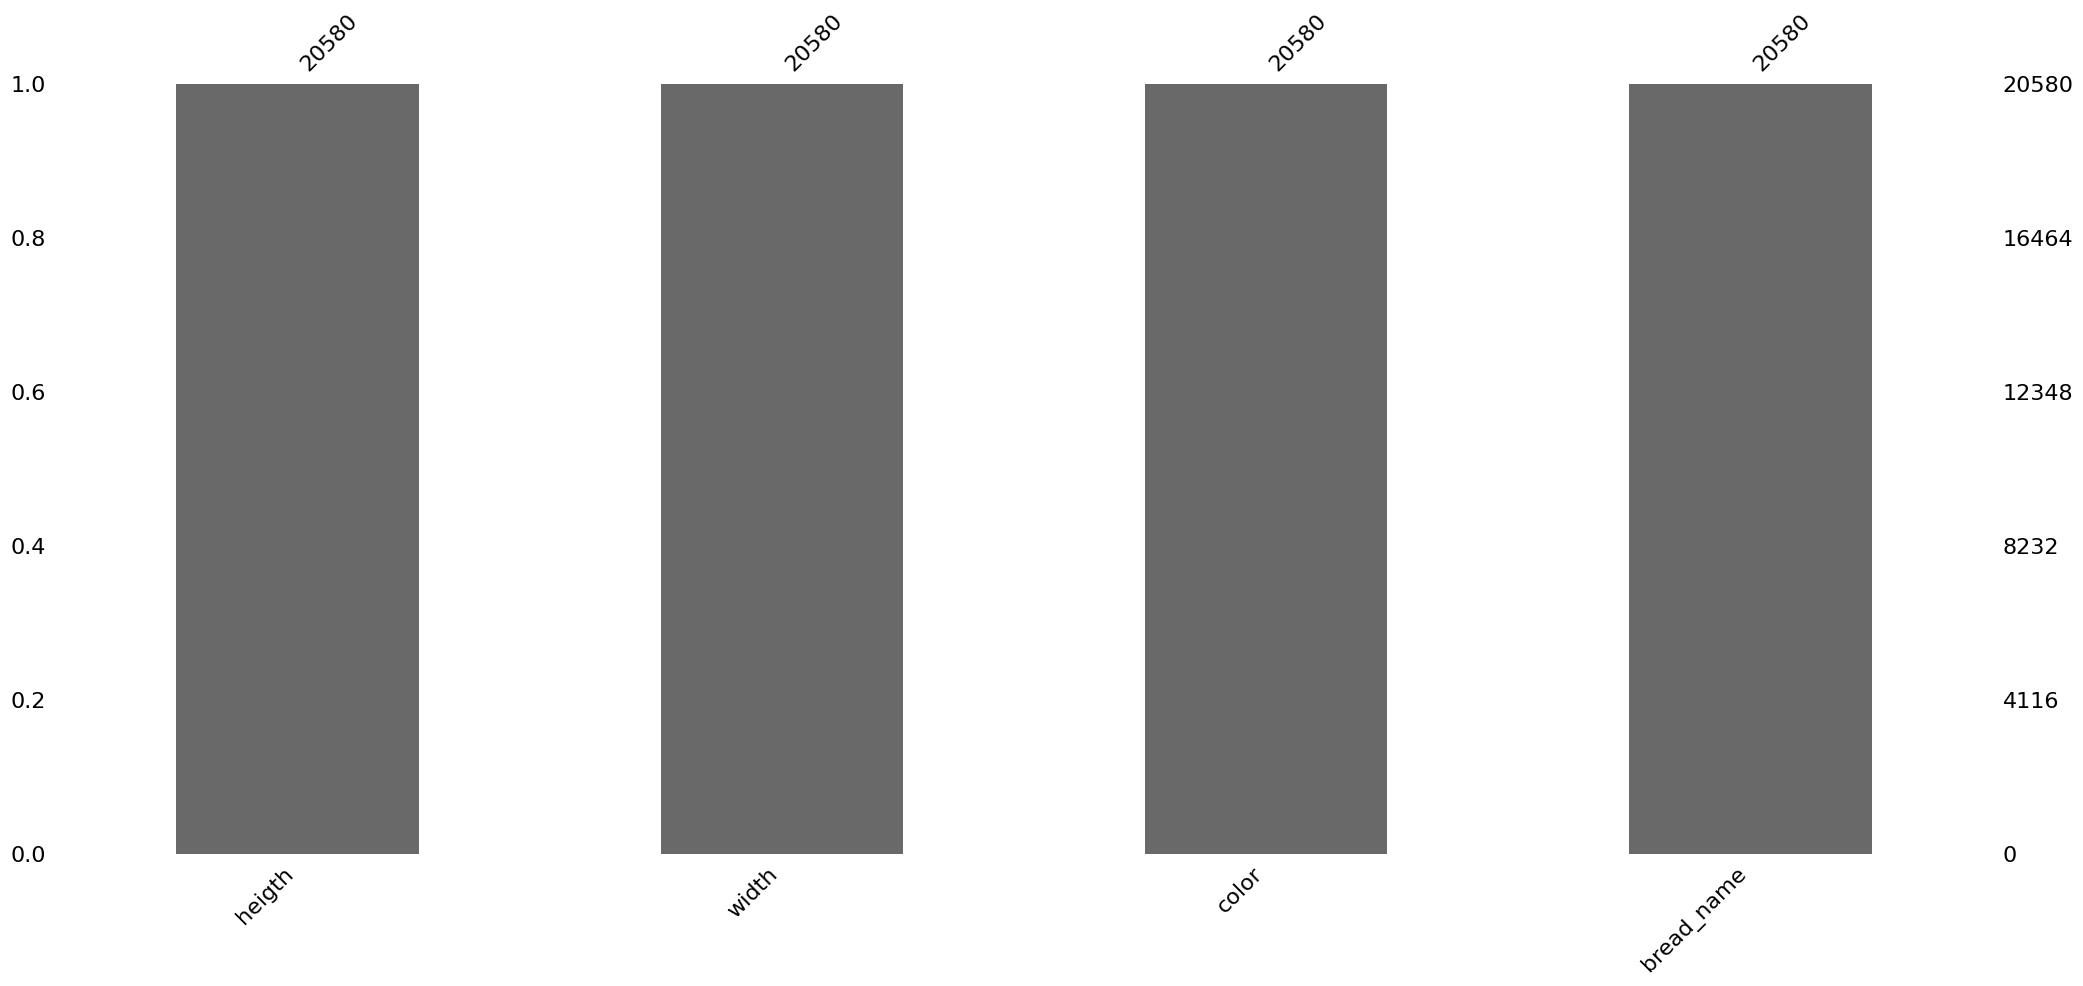

In [19]:
show_informations(df_img, 'analyse du dataframe image')

In [20]:
df_img.sample(10, random_state=1)

heigth  width  color  \
./datas/Images/n02086240-Shih-Tzu/n02086240_61.jpg     500    375      3   
./datas/Images/n02113186-Cardigan/n02113186_108...     500    375      3   
./datas/Images/n02110806-basenji/n02110806_2627...     495    500      3   
./datas/Images/n02115913-dhole/n02115913_4119.jpg      333    500      3   
./datas/Images/n02108551-Tibetan_mastiff/n02108...     364    351      3   
./datas/Images/n02093991-Irish_terrier/n0209399...     300    400      3   
./datas/Images/n02095314-wire-haired_fox_terrie...     440    555      3   
./datas/Images/n02088238-basset/n02088238_9419.jpg     375    500      3   
./datas/Images/n02091032-Italian_greyhound/n020...     375    500      3   
./datas/Images/n02108915-French_bulldog/n021089...     220    220      3   

                                                           bread_name  
./datas/Images/n02086240-Shih-Tzu/n02086240_61.jpg               Shih  
./datas/Images/n02113186-Cardigan/n02113186_108...           Cardigan  
./datas/Images/n02110806-basenji/n02110806_2627...            basenji  
./datas/Images/n02115913-dhole/n02115913_4119.jpg               dhole  
./datas/Images/n02108551-Tibetan_mastiff/n02108...    Tibetan_mastiff  
./datas/Images/n02093991-Irish_terrier/n0209399...      Irish_terrier  
./datas/Images/n02095314-wire-haired_fox_terrie...               wire  
./datas/Images/n02088238-basset/n02088238_9419.jpg             basset  
./datas/Images/n02091032-Italian_greyhound/n020...  Italian_greyhound  
./datas/Images/n02108915-French_bulldog/n021089...     French_bulldog

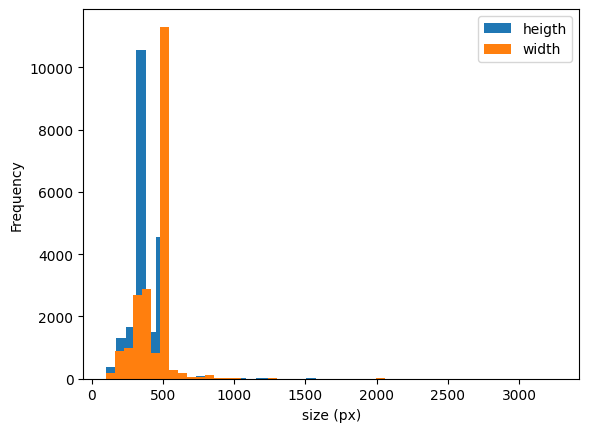

la moyenne (lageur,hauteur) par image:  (385.86, 442.53)


In [21]:
df_img['heigth'].plot.hist(bins=35, alpha=1)
df_img['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()
print("la moyenne (lageur,hauteur) par image: ", (round(df_img['heigth'].mean(),2),round(df_img['width'].mean(),2)))

In [22]:
df_img['color'].value_counts()

3    20579
4        1
Name: color, dtype: int64

toutes les images sont en 3 couleurs (RGB), il n'y a qu'une d'entre elle qui a 4 couleurs RGBA, il faut modifier cette dernière en RGB

In [23]:
 df_img[df_img.color==4]

heigth  width  color  \
./datas/Images/n02105855-Shetland_sheepdog/n021...     189    213      4   

                                                           bread_name  
./datas/Images/n02105855-Shetland_sheepdog/n021...  Shetland_sheepdog

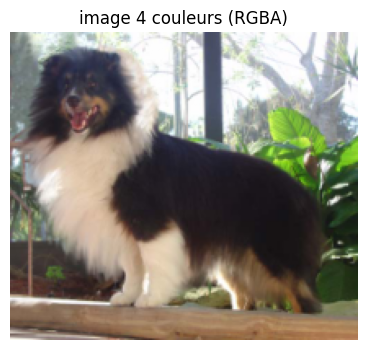

In [24]:
plt.figure(figsize=(10,4))
idx = df_img[df_img.color==4].first_valid_index()
if idx is not None:
    img4 = mpimg.imread(idx)
    plt.imshow(img4)
    plt.title("image 4 couleurs (RGBA)")
    plt.axis('off')
    plt.show()
else:
    print("Aucune ligne avec color==4 trouvée")

In [25]:
# dossier
#name_img4 = idx.split('/')[-1]
#idx=idx.replace(name_img4,'')
#os.chdir(idx)

# image fractionnée
#r_img, g_img, b_img, a_img = cv2.split(img4)

# fusionner l'échelle rgb
#img3 = cv2.merge((r_img, g_img, b_img))

# on écrase l'image RGBA par la RGB
#cv2.imwrite('n02105855_2933.jpg', img3)

#img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#plt.figure(figsize=(10,4))
#plt.imshow(img3_rgb)
#plt.title("Image 3 couleurs (RGB)")
#plt.axis('off')
#plt.show()

### Affichons quelques exemples :

In [26]:
print(path)

./datas/Images


In [27]:
print(df_img.head())

                                                    heigth  width  color  \
./datas/Images/n02092339-Weimaraner/n02092339_2...     500    333      3   
./datas/Images/n02092339-Weimaraner/n02092339_4...     375    500      3   
./datas/Images/n02092339-Weimaraner/n02092339_7...     500    356      3   
./datas/Images/n02092339-Weimaraner/n02092339_3...     350    349      3   
./datas/Images/n02092339-Weimaraner/n02092339_5...     500    410      3   

                                                    bread_name  
./datas/Images/n02092339-Weimaraner/n02092339_2...  Weimaraner  
./datas/Images/n02092339-Weimaraner/n02092339_4...  Weimaraner  
./datas/Images/n02092339-Weimaraner/n02092339_7...  Weimaraner  
./datas/Images/n02092339-Weimaraner/n02092339_3...  Weimaraner  
./datas/Images/n02092339-Weimaraner/n02092339_5...  Weimaraner  


In [28]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

Num = 6  # Nombre d'images à afficher par classe
Num_classes = 5  # Nombre de classes à afficher

# Sélection aléatoire de quelques classes
breed_samples = np.random.choice(data['Id_breed'].unique(), Num_classes)

base_path = Path("./datas/images").resolve()  # Chemin absolu vers le répertoire de base des images

for breed in breed_samples:
    breed_path = base_path / breed  # Chemin du sous-dossier pour la race actuelle

    #print(f"Tentative d'accès au dossier: {breed_path}")  # Ceci affichera le chemin absolu

    # Récupérer les images du sous-dossier de la race actuelle
    try:
        all_files = os.listdir(breed_path)
        images = [f for f in all_files if f.endswith('.jpg')][:Num]  # prendre seulement 'Num' images

    except FileNotFoundError:
        print(f"Erreur avec la classe {breed} : Le chemin d’accès est introuvable")
        continue

    fig = plt.figure(figsize=(12,4))
    plt.suptitle("{}".format(breed.split("-")[1]), y=.01, color="black", fontsize=17)

    for i, img_name in enumerate(images):
        img_path = breed_path / img_name
        try:
            #print(f"Tentative de chargement de l'image depuis: {img_path}")
            img = mpimg.imread(str(img_path))
            plt.subplot(1, Num, i+1)
            plt.imshow(img)
            plt.axis('off')
        except Exception as e:
            print(f"Erreur lors du chargement de l'image depuis {img_path}. Erreur: {e}")
    plt.show()

Erreur avec la classe n02107683-Bernese_mountain_dog : Le chemin d’accès est introuvable
Erreur avec la classe n02096051-Airedale : Le chemin d’accès est introuvable
Erreur avec la classe n02088094-Afghan_hound : Le chemin d’accès est introuvable
Erreur avec la classe n02100583-vizsla : Le chemin d’accès est introuvable
Erreur avec la classe n02089867-Walker_hound : Le chemin d’accès est introuvable


Les images sont très différentes les unes des autres, il faut donc procéder a un esemble de transformations pour les équilibrer

## Augmentations

Les transformations d'images, souvent appelées augmentations de données, jouent un rôle crucial dans le deep learning, en particulier dans la formation de modèles de vision par ordinateur. Elles permettent d'enrichir le jeu de données sans collecter de nouvelles images, rendant le modèle plus robuste et améliorant sa capacité de généralisation.

Voici quelques transformations couramment utilisées pour l'augmentation des données dans la vision par ordinateur :

1. **Rotation** : Faire pivoter l'image d'un certain angle.

2. **Translation** : Déplacer l'image horizontalement ou verticalement.

3. **Redimensionnement (Rescaling)** : Modifier la taille de l'image.

4. **Recadrage (Cropping)** : Découper une partie de l'image.

5. **Miroir (Flip)** : Retourner l'image horizontalement ou verticalement.

6. **Modification de la luminosité et du contraste** : Augmenter ou diminuer la luminosité et le contraste de l'image.

7. **Bruit** : Ajouter un bruit aléatoire à l'image, comme le bruit gaussien.

8. **Normalisation** : Réduire la moyenne et la variance de l'image.

9. **Blanchiment (Whitening)** : Réduire la corrélation entre les pixels adjacents.

10. **Zoom** : Augmenter ou diminuer le zoom de l'image.

11. **Shear** : Décaler une partie de l'image, donnant un effet de "cisaillement".

12. **Changement de couleur** : Modifier les niveaux de RGB ou convertir l'image en niveaux de gris.

13. **Élastic deformation** : Appliquer des distorsions élastiques sur l'image.

14. **Rotation aléatoire** : Faire pivoter l'image d'un angle aléatoire dans une certaine plage.

15. **Cutout** : Supprimer aléatoirement des petites parties/régions de l'image.

16. **Mix-up et CutMix** : Ces techniques combinent des portions de deux images et leurs étiquettes pour produire une nouvelle image.

17. **Jittering** : Ajouter des variations aléatoires de couleur.

18. **PCA Jittering** : Appliquer des modifications aléatoires basées sur l'analyse en composantes principales (PCA) des couleurs.

Ces augmentations peuvent être appliquées individuellement ou en combinaison. Lors de l'application d'augmentations, il est essentiel de s'assurer qu'elles reflètent les variations que le modèle pourrait rencontrer dans des situations réelles, pour éviter de le rendre confus ou de réduire sa performance.

Des bibliothèques comme `augmentor`, `albumentations`, et `imgaug` en Python offrent une large gamme d'opérations d'augmentation d'image pour la formation de modèles de deep learning.

### Amélioration du contraste

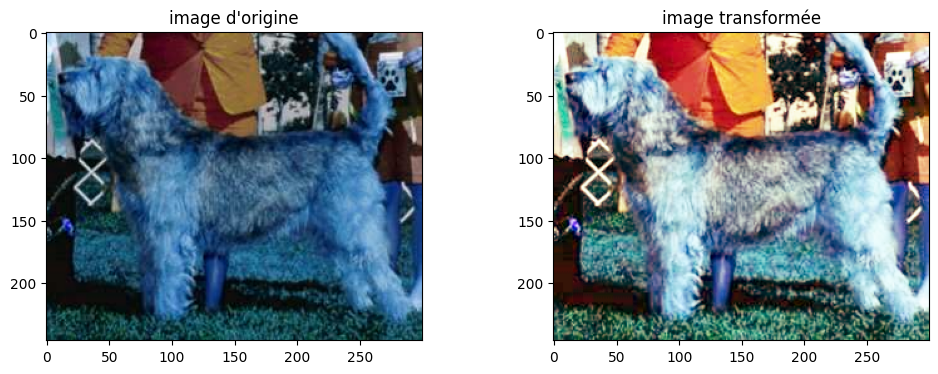

In [29]:
uri = df_img.index[np.random.randint(1000)]
image = cv2.imread(uri)
# Equalization
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# Show both images
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("image d'origine")
plt.subplot(1, 2, 2)
plt.imshow(image_eq)
plt.title("image transformée")
plt.show()

### Suppression du bruit

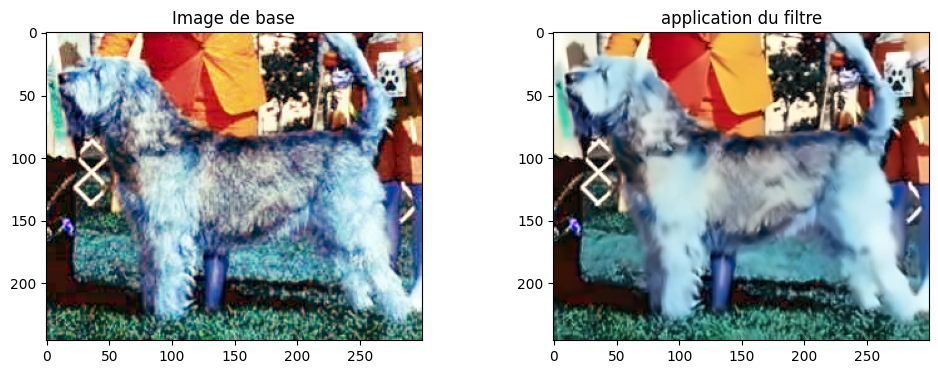

In [30]:
# Apply non-local means filter on test img
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image_eq)
plt.title("Image de base")
plt.subplot(1, 2, 2)
plt.imshow(img_nlf)
plt.title("application du filtre")
plt.show()

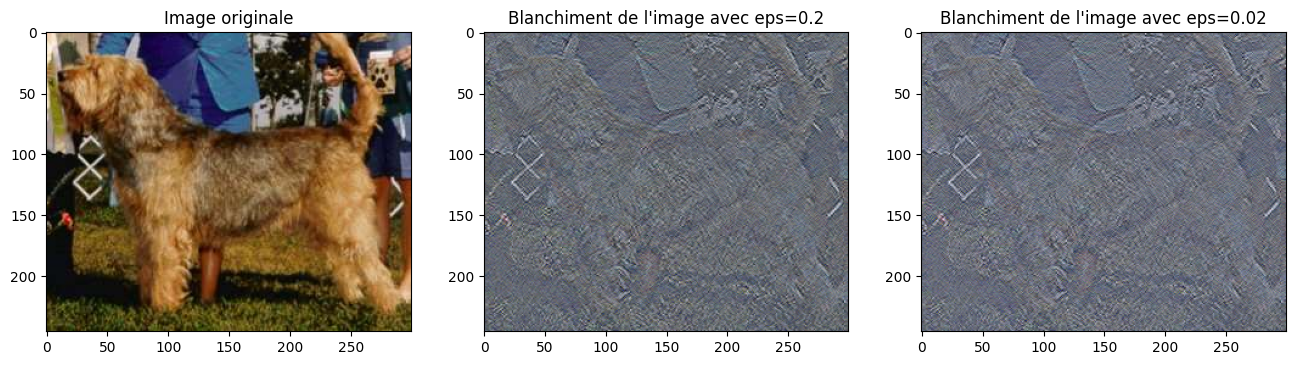

In [31]:
def whitening_channel(channel, eps):
    """Whitening for single channel."""
    channel = channel - channel.mean(axis=0)
    cov_matrix = np.cov(channel, rowvar=False)
    U, S, _ = np.linalg.svd(cov_matrix)
    channel_whitened = U.dot(np.diag(1.0/np.sqrt(S + eps))).dot(U.T).dot(channel.T).T
    return normalize_channel(channel_whitened)

def normalize_channel(channel):
    """Normalize channel values to range [0, 255]."""
    channel_min, channel_max = channel.min(), channel.max()
    return ((channel - channel_min) / (channel_max - channel_min) * 255).astype(np.uint8)

def zca_whitening(image, eps):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    channels = cv2.split(image_rgb)

    whitened_channels = [whitening_channel(channel, eps) for channel in channels]

    whitened_image = cv2.merge(whitened_channels)
    return whitened_image

image = cv2.imread(uri)
x_1 = zca_whitening(image, 0.2)
x_2 = zca_whitening(image, 0.02)

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.subplot(1, 3, 2)
plt.imshow(x_1)
plt.title("Blanchiment de l'image avec eps=0.2")
plt.subplot(1, 3, 3)
plt.imshow(x_2)
plt.title("Blanchiment de l'image avec eps=0.02")
plt.show()

### augmentation de données

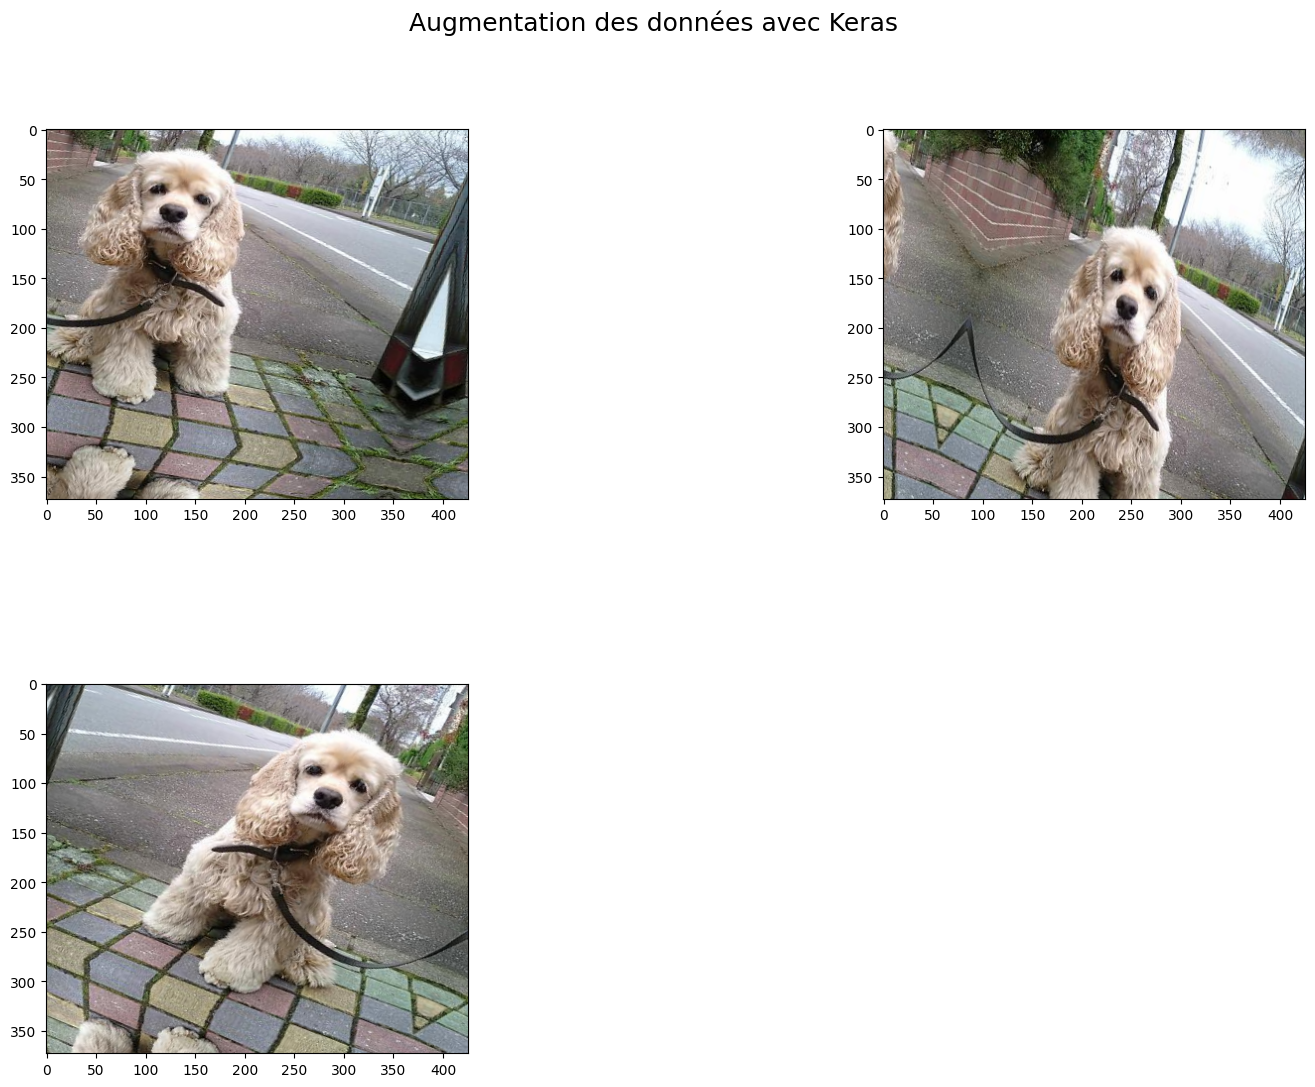

In [32]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

# Convert an image to array
x = mpimg.imread(df_img.index.values[4112])
x = x.reshape((1,) + x.shape)

i = 0
fig = plt.figure(figsize=(18, 12))
for batch in datagen.flow(x, batch_size=1):
    #ax = fig.add_subplot(5, 3, i+1)
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    i += 1
    #if i % 15 == 0:
    if i % 3 == 0:
        break

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle("Augmentation des données avec Keras", fontsize=18)
plt.show()

# faire moins d'augmentation pour entrainer sinon cela va prendre trop temps
# pour l'entraintement itérer 2 ou 3 fois max pour avoir un résultat rapide et pouvoir corriger plus efficacement plutot que de perdre du temps
# une fois que c'est fini on peut en ajouter plus pour montrer le résultat

In [33]:
#data['Id_breed'].iloc[0]
data

Id_breed          breed_name         Id   nb
0            n02092339-Weimaraner          Weimaraner  n02092339  160
1    n02096294-Australian_terrier  Australian_terrier  n02096294  196
2      n02102040-English_springer    English_springer  n02102040  159
3            n02091635-otterhound          otterhound  n02091635  151
4          n02100877-Irish_setter        Irish_setter  n02100877  155
..                            ...                 ...        ...  ...
115              n02100583-vizsla              vizsla  n02100583  154
116            n02111129-Leonberg            Leonberg  n02111129  210
117     n02113799-standard_poodle     standard_poodle  n02113799  159
118    n02113712-miniature_poodle    miniature_poodle  n02113712  155
119       n02093991-Irish_terrier       Irish_terrier  n02093991  169

[120 rows x 4 columns]

In [34]:
import os
import glob
import random

def get_image_paths_from_id_breed(id_breed):
    """
    Récupère les chemins des images pour une race donnée.

    Args:
        id_breed: L'identifiant de la race.

    Returns:
        Une liste de chemins d'images.
    """

    base_path = "./datas/Images"
    image_paths = glob.glob(os.path.join(base_path, str(id_breed), "*.jpg"))

    #if len(image_paths) >= 250:
    return image_paths#[:250]
    #else:
    #    return []

#def get_image_paths_from_id_breed(id_breed):
#    base_path = "./datas/Images"
#    image_paths = glob.glob(os.path.join(base_path, id_breed, "*.jpg"))
#    return image_paths

# Testons la fonction
print(get_image_paths_from_id_breed(data['Id_breed'].iloc[0]))

['./datas/Images/n02092339-Weimaraner/n02092339_2510.jpg', './datas/Images/n02092339-Weimaraner/n02092339_4214.jpg', './datas/Images/n02092339-Weimaraner/n02092339_7812.jpg', './datas/Images/n02092339-Weimaraner/n02092339_3306.jpg', './datas/Images/n02092339-Weimaraner/n02092339_5818.jpg', './datas/Images/n02092339-Weimaraner/n02092339_1331.jpg', './datas/Images/n02092339-Weimaraner/n02092339_5137.jpg', './datas/Images/n02092339-Weimaraner/n02092339_5120.jpg', './datas/Images/n02092339-Weimaraner/n02092339_8029.jpg', './datas/Images/n02092339-Weimaraner/n02092339_93.jpg', './datas/Images/n02092339-Weimaraner/n02092339_6077.jpg', './datas/Images/n02092339-Weimaraner/n02092339_1796.jpg', './datas/Images/n02092339-Weimaraner/n02092339_821.jpg', './datas/Images/n02092339-Weimaraner/n02092339_767.jpg', './datas/Images/n02092339-Weimaraner/n02092339_205.jpg', './datas/Images/n02092339-Weimaraner/n02092339_6269.jpg', './datas/Images/n02092339-Weimaraner/n02092339_2640.jpg', './datas/Images/n0

In [ ]:
#identification des images non conformes
X = []
y = []
ref_shape = None
cpt = 0

for index, row in data.iterrows():
    #if cpt >= 10:
    #    break

    image_paths = get_image_paths_from_id_breed(row['Id_breed'])

    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_processed = zca_whitening(image, 0.1)

        if ref_shape is None:
            ref_shape = image_processed.shape
        else:
            if image_processed.shape != ref_shape:
                print(f"Shape mismatch! Expected {ref_shape} but got {image_processed.shape} for image {image_path}")

                #cpt += 1
                #if cpt >= 10:
                #    break

                continue  # skip this image

        X.append(image_processed)
        y.append(row['Id'])


Shape mismatch! Expected (500, 333, 3) but got (375, 500, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_4214.jpg
Shape mismatch! Expected (500, 333, 3) but got (500, 356, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_7812.jpg
Shape mismatch! Expected (500, 333, 3) but got (350, 349, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_3306.jpg
Shape mismatch! Expected (500, 333, 3) but got (500, 410, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_5818.jpg
Shape mismatch! Expected (500, 333, 3) but got (431, 500, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_1331.jpg
Shape mismatch! Expected (500, 333, 3) but got (375, 500, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_5137.jpg
Shape mismatch! Expected (500, 333, 3) but got (500, 323, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_5120.jpg
Shape mismatch! Expected (500, 333, 3) but got (375, 500, 3) for image ./datas/Images/n02092339-Weimaraner/n02092339_8

In [ ]:
%%time
import tqdm

# def preprocess_data(dataframe, nb_images, target_shape=(500, 333, 3)):
#     num_images = len(dataframe)
#     X = []
#     y = []

#     for index, row in tqdm.notebook.tqdm(dataframe.iterrows()):
#         image_paths = get_image_paths_from_id_breed(row['Id_breed'])
#         image_paths = image_paths[:nb_images]
#         for image_path in image_paths:
#             # Read and Resize
#             image = cv2.imread(image_path)
#             image_resized = cv2.resize(image, (target_shape[1], target_shape[0]))

#             # Equalization
#             r_image, g_image, b_image = cv2.split(image_resized)
#             r_image_eq = cv2.equalizeHist(r_image)
#             g_image_eq = cv2.equalizeHist(g_image)
#             b_image_eq = cv2.equalizeHist(b_image)
#             image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

#             # Débruitage à l'aide de NLM
#             img_nlf = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)

#             # ZCA Whitening
#             image_processed = zca_whitening(img_nlf, 0.1)

#             X.append(image_processed)
#             y.append(row['Id'])

#     X = np.array(X, dtype=np.float32)
#     y = np.array(y)

#     return X, y


# def preprocess_data(dataframe, target_shape=(500, 333, 3)):
#     num_images = len(dataframe)
#     X = []
#     y = []

#     for index, row in tqdm.notebook.tqdm(dataframe.iterrows()):
#         image_paths = get_image_paths_from_id_breed(row['Id_breed'])
#         for image_path in image_paths:
#             # Read and Resize
#             image = cv2.imread(image_path)
#             image_resized = cv2.resize(image, (target_shape[1], target_shape[0]))

#             # Equalization
#             r_image, g_image, b_image = cv2.split(image_resized)
#             r_image_eq = cv2.equalizeHist(r_image)
#             g_image_eq = cv2.equalizeHist(g_image)
#             b_image_eq = cv2.equalizeHist(b_image)
#             image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

#             # Débruitage à l'aide de NLM
#             img_nlf = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)

#             # ZCA Whitening
#             image_processed = zca_whitening(img_nlf, 0.1)

#             X.append(image_processed)
#             y.append(row['Id'])

#     X = np.array(X, dtype=np.float32)
#     y = np.array(y)

#     return X, y


# -------------------------------------------------------------------------------

# def preprocess_data(dataframe, nb_images=10, target_shape=(500, 333, 3)):
#     num_images = len(dataframe)
#     X = []
#     y = []

#     if num_images > 0:
#         for index, row in dataframe.iterrows():#tqdm.notebook.tqdm(dataframe.iterrows()):
#             image_paths = get_image_paths_from_id_breed(row['Id_breed'])
#             if len(image_paths) >= nb_images:
#                 for image_path in image_paths[:nb_images]:
#                     # Read and Resize
#                     print(image_path)
#                     image = cv2.imread(image_path)
#                     image_resized = cv2.resize(image, (target_shape[1], target_shape[0]))

#                     # Equalization
#                     r_image, g_image, b_image = cv2.split(image_resized)
#                     r_image_eq = cv2.equalizeHist(r_image)
#                     g_image_eq = cv2.equalizeHist(g_image)
#                     b_image_eq = cv2.equalizeHist(b_image)
#                     image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

#                     # Débruitage à l'aide de NLM
#                     img_nlf = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)

#                     # ZCA Whitening
#                     image_processed = zca_whitening(img_nlf, 0.1)

#                     X.append(image_processed)
#                     y.append(row['Id'])
#                     print("treated")
#             else:
#               print("pas assez d'image à traiter pour " + row['Id_breed'] + " " + len(image_paths))

#     X = np.array(X, dtype=np.float32)
#     y = np.array(y)

#     return X, y

# def preprocess_data(dataframe, nb_images=10, target_shape=(500, 333, 3)):
#     X = []
#     y = []

#     # Group by Id_breed
#     grouped = dataframe.groupby('Id_breed')

#     for id_breed, group in grouped:
#         image_paths = get_image_paths_from_id_breed(id_breed)
#         if len(image_paths) >= nb_images:
#             for image_path in image_paths[:nb_images]:
#                 # Read and Resize
#                 #print(image_path)
#                 image = cv2.imread(image_path)
#                 image_resized = cv2.resize(image, (target_shape[1], target_shape[0]))

#                 # Equalization
#                 r_image, g_image, b_image = cv2.split(image_resized)
#                 r_image_eq = cv2.equalizeHist(r_image)
#                 g_image_eq = cv2.equalizeHist(g_image)
#                 b_image_eq = cv2.equalizeHist(b_image)
#                 image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

#                 # Débruitage à l'aide de NLM
#                 img_nlf = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)

#                 # ZCA Whitening
#                 image_processed = zca_whitening(img_nlf, 0.1)

#                 X.append(image_processed)
#                 y.append(group['Id'].iloc[0])  # assuming all Ids in the same group are the same
#                 #print("treated")
#         else:
#             print(f"Pas assez d'images à traiter pour {id_breed}, nombre d'images: {len(image_paths)} pour {nb_images}")

#     X = np.array(X, dtype=np.float32)
#     y = np.array(y)

#     return X, y

import numpy as np

def zca_whitening(image, epsilon=1e-5):
    """
    Applique le ZCA Whitening sur une image.

    Args:
        image (np.ndarray): L'image à traiter.
        epsilon (float): Un petit nombre pour éviter la division par zéro.

    Returns:
        np.ndarray: L'image après ZCA Whitening.
    """
    # Aplatir l'image en 2D (hauteur * largeur, canaux)
    image_flat = image.reshape((-1, 3))

    # Calculer la matrice de covariance
    cov_matrix = np.cov(image_flat, rowvar=False)

    # Obtenir les valeurs propres et les vecteurs propres de la matrice de covariance
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Créer la matrice de blanchiment ZCA
    zca_matrix = np.dot(eigenvectors, np.dot(np.diag(1.0 / np.sqrt(eigenvalues + epsilon)), eigenvectors.T))

    # Appliquer la matrice de blanchiment ZCA à l'image aplatie
    image_zca = np.dot(image_flat, zca_matrix)

    # Remettre l'image à sa forme originale
    image_zca_rescaled = image_zca.reshape(image.shape)

    # Optionnel : re-échelle pour le rendre visible (en supposant que les valeurs sont en uint8)
    image_zca_rescaled = (image_zca_rescaled - image_zca_rescaled.min()) / (image_zca_rescaled.max() - image_zca_rescaled.min()) * 255.0
    image_zca_rescaled = np.round(image_zca_rescaled).astype(np.uint8)

    return image_zca_rescaled



def process_single_image(image_path, target_shape=(500, 333, 3)):
    # Read and Resize
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (target_shape[1], target_shape[0]))

    # Equalization
    r_image, g_image, b_image = cv2.split(image_resized)
    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)
    image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

    # Débruitage à l'aide de NLM
    img_nlf = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)

    # ZCA Whitening
    image_processed = zca_whitening(img_nlf, 0.1)

    return image_processed

def preprocess_data(dataframe, target_shape=(500, 333, 3)):   #nb_images,
    X = []
    y = []

    # Group by Id_breed
    grouped = dataframe.groupby('Id_breed')

    for id_breed, group in grouped:
        image_paths = get_image_paths_from_id_breed(id_breed)
        #if len(image_paths) >= nb_images:
        for image_path in image_paths:#[:nb_images]:
            image_processed = process_single_image(image_path, target_shape)

            X.append(image_processed)
            y.append(group['Id'].iloc[0])  # assuming all Ids in the same group are the same
        #else:
        #    print(f"Pas assez d'images à traiter pour {id_breed}, nombre d'images: {len(image_paths)} pour {nb_images}")

    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    return X, y


In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
data[:1]

In [ ]:
import cv2
from functools import partial

#### Entainement du modèle CNN, on va prendre un certains nombre d'images pour limiter les calculs, par exemple le top 10

In [ ]:
import os

image_path = './datas/Images/n02085620-Chihuahua/n02085620_10074.jpg'
image_exists = os.path.exists(image_path)
print("Image exists:", image_exists)

import cv2
import matplotlib.pyplot as plt

image = cv2.imread(image_path)

# Convertir de BGR à RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()


In [ ]:
image_paths = get_image_paths_from_id_breed(row['Id_breed'])
print(f'Image paths for ID {row["Id_breed"]}: {image_paths}')

In [1]:
# import time
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from concurrent.futures import ThreadPoolExecutor

# # Nombre de races et d'images à traiter
# nb_breeds = 1  # Réduit de 500 à 100

# # Mesure du temps de début
# start_time = time.perf_counter()

# # Sélection des URIs d'images et des noms de races pour le nombre de races donné
# total_images = np.sum(data.nb.values[0:nb_breeds])
# print("Total images:", total_images)

# # Fusion des dataframes pour obtenir toutes les informations nécessaires
# combined_df = pd.merge(df_img, data, left_on='bread_name', right_on='breed_name', how='left')

# # Échantillonnage aléatoire pour réduire la taille du dataframe
# #combined_df = combined_df.sample(frac=0.1)  # Prend 50% des données
# combined_df = combined_df[combined_df['Id_breed'].isin(data.Id_breed.values[0:nb_breeds])]

# print("Size of combined DataFrame:", len(combined_df))

# # Prétraitement des images
# X, y = preprocess_data(combined_df)

# # Encodage des labels
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y)

# # Calcul et affichage du temps écoulé
# elapsed_time = time.perf_counter() - start_time
# print("Preprocessing time :", round(elapsed_time, 1), "seconds")
# print("Number of images preprocessed:", X.shape[0])


import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
import pickle

# Nombre de races et d'images à traiter
nb_breeds = 50  # nombre de races
#nb_images = 1000  # Nombre d'images à traiter par race

def load_or_preprocess_data(combined_df):#, nb_images):
    # Vérifiez si le fichier existe
    if os.path.exists('preprocessed_images.pkl'):
        # Si le fichier existe, chargez-le
        with open('preprocessed_images.pkl', 'rb') as f:
            X = pickle.load(f)
            y = pickle.load(f)
    else:
        # Si le fichier n'existe pas, appelez la fonction preprocess_data()
        X, y = preprocess_data(combined_df)#, nb_images)
        # Enregistrez les données prétraitées
        with open('preprocessed_images.pkl', 'wb') as f:
            pickle.dump(X, f)
            pickle.dump(y, f)
    return X, y

# Mesure du temps de début
start_time = time.perf_counter()

# Sélection des URIs d'images et des noms de races pour le nombre de races donné
total_images = np.sum(data.nb.values[0:nb_breeds])
print("Total images:", total_images)

# Fusion des dataframes pour obtenir toutes les informations nécessaires
combined_df = pd.merge(df_img, data, left_on='bread_name', right_on='breed_name', how='left')

# Échantillonnage aléatoire pour réduire la taille du dataframe
#combined_df = combined_df.sample(frac=0.1)  # Prend 50% des données
combined_df = combined_df[combined_df['Id_breed'].isin(data.Id_breed.values[0:nb_breeds])]

print("Size of combined DataFrame:", len(combined_df))

# Prétraitement des images
#X, y = preprocess_data(combined_df, nb_images)

X, y = load_or_preprocess_data(combined_df)#, nb_images)

# Encodage des labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Calcul et affichage du temps écoulé
elapsed_time = time.perf_counter() - start_time
print("Preprocessing time :", round(elapsed_time, 1), "seconds")
print("Number of images preprocessed:", X.shape[0])

NameError: ignored

#### préparation des données de test et d'entraintement

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

NameError: ignored

In [ ]:
# augmentons les données d'entraintement avec remise à l'echelle des données de test.
# pour rappel l'augmentation des données est utilisée pour générer des données artificiellement en plus pour l'entrainement à partir de l'ensemble de données de base
# en appliquant différentes transformations, cela permet d'éviter le surapprentisage.

df_train = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', validation_split=0.2)
df_test = ImageDataGenerator(rescale=1./255)

In [ ]:
import keras
from keras.applications import VGG16
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Créer un modèle séquentiel
model = keras.Sequential()

# Ajouter le modèle VGG16 au modèle séquentiel, y compris la couche supérieure
vgg16_model = VGG16(weights='imagenet', include_top=True)
model.add(vgg16_model)

# Geler les poids du modèle VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Ajouter une nouvelle couche dense avec 133 neurones au modèle séquentiel
new_layer = Dense(133, activation='softmax')
model.add(new_layer)

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])


# Créer un encodeur de labels
encoder = LabelEncoder()

# Encoder les labels des données d'entraînement
y_train_encoded = encoder.fit_transform(y_train)

# Encoder les labels des données de test
y_test_encoded = encoder.fit_transform(y_test)

# Convertir les labels en vecteurs binaires
y_train_one_hot = to_categorical(y_train_encoded, num_classes=133)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=133)

# Entraîner le modèle sur les données d'entraînement
history = model.fit(X_train_resized, y_train_one_hot, epochs=10, validation_data=(X_test_resized, y_test_one_hot))

# Évaluer le modèle sur les données de test
model.evaluate(X_test_resized, y_test_one_hot)

# Sauver le modèle
model.save('model_vgg16.h5')


In [ ]:
print("Available keys: ", history.history.keys())

In [ ]:
# courbe d'apprentissage modèle VGG16
plt.figure(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training set', 'Validation set'], loc='upper left')

In [ ]:
# Matrice de confusion VGG16
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)  # Attention, utilisez y_test_one_hot car y_test n'est pas one-hot encodé
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

plt.figure(figsize=(12, 12))
plt.scatter(y_true, y_pred_classes, alpha=0.6)
plt.xlabel('True Classes')
plt.ylabel('Predicted Classes')
plt.title('Scatter Plot of Confusion Matrix')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from keras.models import load_model


# Charger le modèle pré-entraîné
model = load_model('model_vgg16.h5')

# def test_image(image_path):
#     """
#     Prédire la race d'un chien à partir d'une image.

#     Args:
#         image_path: Le chemin d'accès à l'image.

#     Returns:
#         La prédiction de la race du chien.
#     """

#     # Prétraiter l'image
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, (224, 224))
#     image = np.expand_dims(image, axis=0)

#     # Prédire la race du chien
#     pred = model.predict(image)

#     # Sauver l'image pré traitée
#     save_image(image)

#     # Afficher la prédiction
#     return pred[0]

# Vérification du nombre de classes dans l'encodeur et du modèle
print("Number of classes in encoder:", len(encoder.classes_))
print("Number of output neurons in the model:", model.output_shape[-1])

def test_image(image_path):
    # Prétraiter l'image

    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    #image = process_single_image(image_path)

    pred = model.predict(image)
    predicted_index = np.argmax(pred, axis=1)[0]

    # Vérification
    if predicted_index >= len(encoder.classes_):
        print(f"Warning: Predicted index {predicted_index} is out of range of encoder classes.")
        return "Unknown class"

    print("Predicted index:", predicted_index)
    print("All predicted probabilities:", pred)

    try:
        classe = encoder.inverse_transform([predicted_index])[0]
        # Sauver l'image prétraitée
        save_image(image[0])
    except ValueError as e:
        print(f"Error: {e}")
        return None

    return classe


# def test_image(image_path):
#     """
#     Prédire la race d'un chien à partir d'une image.

#     Args:
#         image_path: Le chemin d'accès à l'image.

#     Returns:
#         Le nom de la race du chien.
#     """

#     # Prétraiter l'image
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, (224, 224))
#     image = np.expand_dims(image, axis=0)

#     # Prédire la race du chien
#     pred = model.predict(image)

#     # Sauver l'image pré traitée
#     save_image(image)

#     # Afficher la prédiction
#     classe = encoder.inverse_transform(np.argmax(pred, axis=1))[0]
#     return classe


def save_image(image):
    """
    Sauvegarder une image pré traitée.

    Args:
        image: L'image pré traitée.

    Returns:
        Aucun.
    """

    #os.makedirs('datas/Images', exist_ok=True)
    cv2.imwrite('image_preprocessed.jpg', image)

# Prédire la race d'un chien
pred = test_image('/content/datas/Images/n02098413-Lhasa/n02098413_11519.jpg')

# Afficher la prédiction
print('La race de chien est {}'.format(pred))

In [ ]:
# alorithme CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import glob
import os
import cv2


# traitement de l'image
X, y = preprocess_data(combined_df)

# Conversion des labels textuels en labels numériques
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Séparation des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Création de l'architecture CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 333, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(set(y)), activation='softmax')  # Nombres de classes
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.save("model_cnn.h5")

# Méthode pour tester une image
def test_single_image(image_path):
    image_processed = process_single_image(image_path)
    image_processed = np.expand_dims(image_processed, axis=0)  # Augmenter la dimension pour correspondre à l'input du modèle
    prediction = model.predict(image_processed)
    label_encoded = np.argmax(prediction)
    label = encoder.inverse_transform([label_encoded])[0]
    return label

# Test avec une image aléatoire
random_image_path = "./datas/Images/n02086910-papillon/n02086910_2691.jpg"
predicted_label = test_single_image(random_image_path)
print(f"Predicted label: {predicted_label}")


In [ ]:
# courbe d'apprentissage modèle CNN
plt.figure(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training set', 'Validation set'], loc='upper left')

In [ ]:
# Matrice de confusion VGG16
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.show()

In [70]:
# fonction de génération du modèle
from keras.layers import Input

def create_breed_classification_cnn (filt=32, ker_s=(3, 3), wind=(2, 2), strd=2, f_act='relu', nb_breed=120):
    """
    """
    K.clear_session()
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(filters=filt, kernel_size=ker_s, input_shape=(300, 300, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(f_act))
    model.add(MaxPooling2D(pool_size=wind, strides=strd, padding='same'))
    model.add(Dropout(0.25))  # Dropout après MaxPooling pour régularisation

    # Deuxième couche de convolution
    model.add(Conv2D(filters=2*filt, kernel_size=ker_s, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(f_act))
    model.add(MaxPooling2D(pool_size=wind, strides=strd, padding='same'))
    model.add(Dropout(0.25))

    # Troisième couche de convolution
    model.add(Conv2D(filters=4*filt, kernel_size=ker_s, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(f_act))
    model.add(MaxPooling2D(pool_size=wind, strides=strd, padding='same'))
    model.add(Dropout(0.25))

    # Quatrième couche de convolution
    model.add(Conv2D(filters=8*filt, kernel_size=ker_s, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(f_act))

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))

    # Couches entièrement connectées
    model.add(Dense(16*filt, activation=f_act))
    model.add(Dense(nb_breed, activation='softmax'))

    return model

In [71]:
# affichage de l'entraintement
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_param_impact_on_training (result, Columns, name):
    """
    Fonction permettant de tracer des courbes de scores pour différentes valeurs de paramètres dans la liste Columns.

    Paramètres :
    - result : Dictionnaire des résultats historiques du modèle CNN.
    - Colonnes : Liste des valeurs des paramètres.
    - name : Nom du paramètre analysé.
    """
    # Extraire la perte de validation et la précision pour chaque colonne
    val_loss = {k: v.history['val_loss'] for k, v in result.items()}
    val_acc = {k: v.history['val_accuracy'] for k, v in result.items()}

    val_loss_curves = pd.DataFrame(val_loss)
    val_loss_curves.columns = Columns
    val_acc_curves = pd.DataFrame(val_acc)
    val_acc_curves.columns = Columns

    # Définir le style des tracés
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'wspace': 0.5})

    # Tracé de la perte de validation et de la précision pour chaque colonne
    for col in Columns:
        ax[0].plot(val_loss_curves[col], label=col)
        ax[1].plot(val_acc_curves[col], label=col)

    # Définition des titres, des étiquettes, des légendes et des tailles de police
    ax[0].set_title(f"Impact of {name} on the Loss", fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend(fontsize=12)

    ax[1].set_title(f"Impact of {name} on the Accuracy", fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend(fontsize=12)

    # Affichage de la grille pour une meilleure lisibilité
    ax[0].grid(True)
    ax[1].grid(True)

    # affichage
    plt.show()


In [73]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [76]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def model_cnn(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', num_classes=120):
    model = Sequential()

    # Créer des nouvelles instances de couches d'activation pour chaque couche
    for n_filters in [filters, 2*filters, 4*filters]:
        model.add(layers.Conv2D(n_filters, kernel_size, strides, padding))
        model.add(layers.Activation(activation))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


def train_model_with_activation(activation_func, train_data, val_data, epochs=20, batch_size=16):
    model = model_cnn(activation=activation_func)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=val_data)

    return model, history

act_fun = ['relu', 'sigmoid', 'selu', 'tanh']
result = {}

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles de formation et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for f_act in act_fun:
    result[f_act] = train_model_with_activation(f_act,
                                                train_datagen.flow(X_train, y_train, batch_size=16),
                                                val_datagen.flow(X_val, y_val, batch_size=16))

# Plot the impact of each activation function on training using the improved function
plot_param_impact_on_training(result, act_fun, 'activation function')


Epoch 1/20


UnimplementedError: ignored

In [ ]:
# optimisation

def train_model_with_optimizer(optimizer, train_datagen, X_train, y_train, batch_size=16, epochs=20):
    """
    Entraîne un modèle CNN à partir d'un optimiseur spécifique.
    Retourne l'historique de la formation
    """
    model = model_cnn(16, 3, 2, 2, "relu", 5)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")

    history = model.fit(
        df_train.flow(X_train, y_train, batch_size=batch_size, subset='training'),
        validation_data=df_trainest-ce qe.flow(X_train, y_train, batch_size=batch_size, subset='validation'),
        steps_per_epoch=len(X_train) / 32,
        epochs=epochs
    )

    return history

optimizers = ['adam', 'SGD', 'adamax']
result = {}

for optimizer in optimizers:
    result[optimizer] = train_model_with_optimizer(optimizer, train_datagen, X_train, y_train)

Columns = optimizers
name = 'optimizer'
plot_scores_curves(result, Columns, name)


# ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def train_model_with_activation(activation_func, train_data, val_data, base_model, epochs=20, batch_size=16):
    """
    Entraîne un modèle avec une fonction d'activation spécifiée sur la dernière couche dense.
    """

    # Ajout des couches personnalisées
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation=activation_func)(x)
    predictions = Dense(len(set(y_encoded)), activation='softmax')(x)

    # Composer le modèle
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiler le modèle
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entraîner le modèle
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=epochs)

    return history

# Charger ResNet50 avec des poids pré-entraînés
base_model = ResNet50(weights='imagenet', include_top=False)

# Fonctions d'activation à tester
act_fun = ['relu', 'sigmoid', 'selu', 'tanh']
result = {}

# Générateurs de données
train_data = train_datagen.flow(X_train, y_train, batch_size=16)
val_data = train_datagen.flow(X_test, y_test, batch_size=16)

# Entraîner le modèle pour chaque fonction d'activation et stocker les résultats
for f_act in act_fun:
    result[f_act] = train_model_with_activation(f_act, train_data, val_data, base_model)

# Tracer l'impact de chaque fonction d'activation sur l'entraînement en utilisant la fonction améliorée
plot_param_impact_on_training(result, act_fun, 'activation function')
